In [43]:
from utils import *
from dataset import *
from autoencoder import *
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")


In [44]:
Ashley = True
if Ashley:
    device = "cpu"

In [45]:
data = StepFunctionEventsDataset(4096,[1, 0.5, 0.25])

In [46]:
loader = DataLoader(data, batch_size=1024, shuffle=True)

In [47]:
model = Autoencoder(40, 4, 1, 1, lam = 0.0025)
model = model.to(device)
print(device)
trainer = pl.Trainer(max_epochs=1000, accelerator=device, devices=1)
history = trainer.fit(model, loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name    | Type          | Params
------------------------------------------
0 | encoder | MLP           | 724   
1 | decoder | MLP           | 113   
2 | code    | NaiveEncoding | 0     
------------------------------------------
837       Trainable params
0         Non-trainable params
837       Total params
0.003     Total estimated model params size (MB)


cpu


/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


In [48]:
# Visualize training
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Reusing TensorBoard on port 6006 (pid 15990), started 1:02:20 ago. (Use '!kill 15990' to kill it.)

In [49]:
# Testing data, currently just the training data
test_loader = DataLoader(data, batch_size=4096)
test_batch = next(iter(test_loader))
model.eval()
with torch.no_grad():
    model.encode(test_batch['event_list'])
    z = model.latent.cpu().numpy()


In [50]:
# from sklearn.manifold import TSNE

# # Apply t-SNE
# tsne = TSNE(n_components=2, random_state=42)
# embedding = tsne.fit_transform(z)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embedding = pca.fit_transform(z)

# embedding = z


[[    0.        0.    22955.56  23124.604]
 [    0.        0.    12958.063 13053.465]
 [    0.        0.    13498.192 13597.572]
 ...
 [    0.        0.    13771.967 13873.415]
 [    0.        0.    19713.87  19859.092]
 [    0.        0.    18768.053 18906.283]]


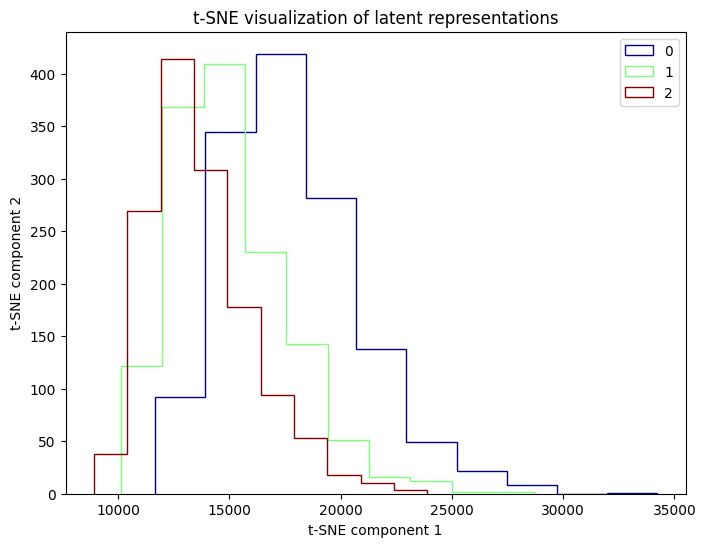

In [51]:
labels = test_batch['type'].numpy()
unique_labels = np.unique(labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
print(z)
plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    idx = labels == label
    plt.hist(z[idx, 2], color=colors[i], histtype='step', label=label)

plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.legend(loc='best')
plt.title('t-SNE visualization of latent representations')
plt.show()

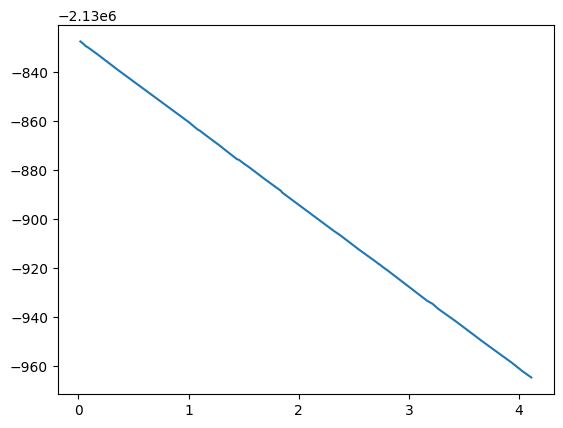

In [52]:
with torch.no_grad():
    coded = model.code(test_batch['event_list'])
    rates = model.decode(coded)
plt.plot(coded[0,:,0], rates[0,:,0])